## 双深度Q网络

在DQN的实现过程中，Q值往往是被高估的。DDQN的方法可以让预估值与真实值比较接近。在DQN中，Q值估计如下：
$$
Q(s_t,a_t) = r_t + \gamma \max_{a}Q(s_{t+1},a)
$$
而在DDQN中，包含两个Q网络，一个网络用于选择动作，另一个网络用于计算Q值。
$$
Q(s_t,a_t)=r_t+\gamma Q'(s_{t+1},\arg\max_aQ(s_{t+1},a))
$$
我们动手实现的时候，有两个Q 网络：会更新的Q 网络和目标Q 网络。所以在DDQN 里面，我们
会用会更新参数的Q 网络去选动作，用目标Q 网络（固定住的网络）计算值。Double DQN除了在更新对期望Q值的近似方式与DQN不同之外，其他都是相同的。

### 程序实现

#### 调用相关的包

In [55]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import math
import random
import gym
import seaborn as sns
import os
import argparse

#### 定义网络

In [56]:
class QNet(nn.Module):
    def __init__(self, n_states, n_actions, hidden_dim=128):
        '''初始化Q网络，为全连接网络
        '''
        super(QNet, self).__init__()
        self.Qnet = nn.Sequential(
            nn.Linear(n_states, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, n_actions)
        )
    
    def forward(self, x):
        '''定义网络结构
        '''
        return self.Qnet(x)
    

#### 定义经验回放
经验回放首先是具有一定容量的，只有存储一定的transition网络才会更新，都则就退回到了之前的逐步更新了。经验回放一般需要两个功能：push将一个transition样本按顺序放到经验回放中，如果满了就把最开始放进去的样本挤掉，因此是队列的数据结构；sample随机采样出一个或者若干个样本，一般是batch_size个供网络更新。

In [57]:
class ReplayBuffer(object):
    def __init__(self, capacity: int) -> None:
        self.capacity = capacity
        self.buffer = deque(maxlen=capacity)
    def push(self, transition):
        self.buffer.append(transition)
    def sample(self, batch_size: int, sequential: bool = False):
        if batch_size > len(self.buffer):
            batch_size = len(self.buffer)
        if sequential:
            rand = random.randint(0, len(self.buffer) - batch_size)
            batch = [self.buffer[i] for i in range(rand, rand + batch_size)]
            return zip(*batch)
        else:
            batch = random.sample(self.buffer, batch_size)
            return zip(*batch)
    def clear(self):
        self.buffer.clear()
    def __len__(self):
        return len(self.buffer)


#### DDQN算法

In [ ]:
class DoubleDQN(object):
    def __init__(self, cfg):
        self.n_states = cfg.n_states
        self.n_actions = cfg.n_actions
        self.device = cfg.device
        self.gamma = cfg.gamma # 折扣因子
        # e-greedy策略相关参数
        self.sample_count = 0 # 用于epsilon的衰减计数
        self.epsilon = cfg.epsilon_start
        self.epsilon_start = cfg.epsilon_start
        self.epsilon_end = cfg.epsilon_end
        self.epsilon_decay = cfg.epsilon_decay

        self.batch_size = cfg.batch_size
        self.target_update = cfg.target_update
        self.policy_net = QNet(self.n_states, self.n_actions, hidden_dim=cfg.hidden_dim).to(self.device)
        self.target_net = QNet(self.n_states, self.n_actions, hidden_dim=cfg.hidden_dim).to(self.device)
        # 复制参数到目标网络
        for target_param, param in zip(self.target_net.parameters(), self.policy_net.parameters()):
            target_param.data.copy_(param.data)
        self.optimizer = torch.optim.Adam(params=self.policy_net.parameters(), lr=cfg.lr)
        self.memory = ReplayBuffer(cfg.memory_capacity)
        self.update_flag = False
    
    def sample_action(self, state):
        self.sample_count += 1
        self.epsilon = self.epsilon_end + (self.epsilon_start - self.epsilon_end) * \
            math.exp(-1. * self.sample_count / self.epsilon_decay)
        if random.random() > self.epsilon:
            state = torch.tensor(state, device=self.device, dtype=torch.float32).unsqueeze(dim=0)
            q_value = self.policy_net(state)
            action = q_value.max(1)[1].item() # 选择Q值最大的动作
        else:
            action = random.randrange(self.n_actions)
        return action
    
    @torch.no_grad()
    def predict_action(self, state):
        state = torch.tensor(state, device=self.device, dtype=torch.float32).unsqueeze(dim=0)
        q_value = self.policy_net(state)
        action = q_value.max(1)[1].item() # 选择Q值最大的动作
        return action
    
    def update(self):
        if len(self.memory) < self.batch_size:
            return
        else:
            if not self.update_flag:
                print("开始更新策略！")
                self.update_flag = True
        # 从经验回放中随机次啊养一个批量的转移
        state_batch, action_batch, reward_barch, next_state_batch, done_batch = self.memory.sample(self.batch_size)
        state_batch = torch.tensor(np.array(state_batch), device=self.device, dtype=torch.float32)
        action_batch = torch.tensor(action_batch, device=self.device, dtype=torch.int64).unsqueeze(1)
        reward_barch = torch.tensor(reward_barch, device=self.device, dtype=torch.float32).unsqueeze(1)
        next_state_batch = torch.tensor(np.array(next_state_batch), device=self.device, dtype=torch.float32)
        done_batch = torch.tensor(done_batch, device=self.device, dtype=torch.float32).unsqueeze(1)
        q_value_batch = self.policy_net(state_batch).gather(1, index=action_batch) # 实际的Q值
        next_q_value_batch = self.policy_net(next_state_batch) # 下一个状态对应的实际策略网络的Q值
        next_target_value_batch = self.target_net(next_state_batch)
        # 将策略网络Q值最大的动作对应的目标网络Q值作为期望的Q值
        next_target_q_value_batch = next_target_value_batch.gather(1, torch.max(next_q_value_batch, 1)[1].unsqueeze(1))
        expected_q_value_batch = reward_barch + self.gamma * next_target_q_value_batch * (1 - done_batch)
        # 计算损失
        loss = nn.MSELoss()(q_value_batch, expected_q_value_batch)
        # 优化更新模型
        self.optimizer.zero_grad()
        loss.backward()
        # clip防止梯度爆炸
        for param in self.policy_net.parameters():
            param.grad.data.clamp_(-1, 1)
        self.optimizer.step()
        if self.sample_count % self.target_update == 0: # 每隔一段时间，策略网络的参数复制给目标网络
            self.target_net.load_state_dict(self.policy_net.state_dict())
            #print("目标参数更新。")


#### 定义训练

In [59]:
def train(env, agent, cfg):
    '''训练
    '''
    print(f"开始训练！")
    print(f"环境：{cfg.env_name}, 算法：{cfg.algo_name}, 设备：{cfg.device}")
    rewards = []
    steps = []
    for i_ep in range(cfg.train_eps):
        ep_rewards = 0
        ep_step = 0
        state = env.reset()
        for _ in range(cfg.ep_max_steps):
            ep_step += 1
            action = agent.sample_action(state)
            next_state, reward, done, _ = env.step(action)
            agent.memory.push((state, action, reward, next_state, done))
            state = next_state
            agent.update()
            ep_rewards += reward
            if done:
                break
        steps.append(ep_step)
        rewards.append(ep_rewards)
        if (i_ep+1) % 10 == 0:
            print(f"回合：{i_ep+1}/{cfg.train_eps}，奖励：{ep_rewards:.1f}，"
                  f"奖励平均值：{np.mean(rewards[-10:]):.1f}，步数：{ep_step}，Epsilon：{agent.epsilon:.3f}")
    print(f"完成训练！")
    env.close()
    return {"rewards": rewards, "steps": steps}

def test(env, agent, cfg):
    '''测试
    '''
    print(f"开始测试！")
    print(f"环境：{cfg.env_name}, 算法：{cfg.algo_name}, 设备：{cfg.device}")
    rewards = []
    steps = []
    for i_ep in range(cfg.test_eps):
        ep_rewards = 0
        ep_step = 0
        state = env.reset()
        for _ in range(cfg.ep_max_steps):
            ep_step += 1
            action = agent.predict_action(state)
            next_state, reward, done, _ = env.step(action)
            state = next_state
            ep_rewards+= reward
            if done:
                break
        rewards.append(ep_rewards)
        steps.append(ep_step)
        print(f"回合：{i_ep+1}/{cfg.test_eps}，奖励：{ep_rewards:.1f}，步数：{ep_step}")
    print(f"完成测试！")
    env.close()
    return {"rewards": rewards, "steps": steps}


#### 定义环境

In [60]:
def all_seed(env,seed = 1):
    ''' 万能的seed函数
    '''
    env.seed(seed) # env config
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed) # config for CPU
    torch.cuda.manual_seed(seed) # config for GPU
    os.environ['PYTHONHASHSEED'] = str(seed) # config for python scripts
    # config for cudnn
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.enabled = False

def env_agent_config(cfg):
    env = gym.make(cfg.env_name)
    all_seed(env,cfg.seed)
    n_states = env.observation_space.shape[0]
    n_actions = env.action_space.n
    print(f"状态空间维度：{n_states}, 动作空间维度：{n_actions}")
    cfg.n_states = n_states
    cfg.n_actions = n_actions
    if torch.cuda.is_available():
        cfg.device = torch.device("cuda")
    else:
        cfg.device = torch.device("cpu")
    agent = DoubleDQN(cfg)
    return env,agent
    

#### 设置参数

In [61]:
def get_args():
    parser = argparse.ArgumentParser(description='Reinforcement learning with DDQN')
    parser.add_argument('--env-name', default="CartPole-v1", type=str, help='环境名称')
    parser.add_argument("--algo_name", default="DoubleDQN", type=str, help="算法名称")
    parser.add_argument("--device", default="cpu", type=str, help="设备名称")

    parser.add_argument("--n_states", default=4, type=int, help="状态数量")
    parser.add_argument("--n_actions", default=2, type=int, help="动作数量")
    parser.add_argument("--train_eps", default=100, type=int, help="训练次数")
    parser.add_argument("--test_eps", default=10, type=int, help="测试次数")
    parser.add_argument("--ep_max_steps", default=200, type=int, help="每个回合的最大步数")
    parser.add_argument("--hidden_dim", default=256, type=int, help="隐藏层维度")

    parser.add_argument("--gamma", default=0.99, type=float, help="折扣因子")
    parser.add_argument("--epsilon_start", default=0.95, type=float, help="随机动作概率")
    parser.add_argument("--epsilon_end", default=0.01, type=float, help="最小随机动作概率")
    parser.add_argument("--epsilon_decay", default=500, type=int, help="随机动作概率衰减")
    parser.add_argument("--target_update", default=4, type=int, help="更新目标网络的频率")
    parser.add_argument("--memory_capacity", default=10000, type=int, help="经验回放的容量")

    parser.add_argument("--lr", default=0.0001, type=float, help="学习率")
    parser.add_argument("--batch_size", default=64, type=int, help="每次训练样本数量")

    parser.add_argument("--seed", default=0, type=int, help="随机种子")

    args = parser.parse_args([])
    args_dict = {**vars(args)}
    # 打印超参数
    print("超参数：")
    print("".join(["="]*80))
    tplt = "{:<20}\t{:<20}\t{:<20}"
    print(tplt.format("参数", "值", "类型"))
    for k, v in args_dict.items():
        print(tplt.format(k, v, str(type(v))))
    print("".join(["="]*80))
    return args

def smooth(data, weight=0.9):  
    '''用于平滑曲线，类似于Tensorboard中的smooth曲线
    '''
    last = data[0] 
    smoothed = []
    for point in data:
        smoothed_val = last * weight + (1 - weight) * point  # 计算平滑值
        smoothed.append(smoothed_val)                    
        last = smoothed_val                                
    return smoothed

def plot_rewards(rewards,cfg, tag='train'):
    ''' 画图
    '''
    sns.set()
    plt.figure()  # 创建一个图形实例，方便同时多画几个图
    plt.title(f"{tag}ing curve on {cfg.device} of {cfg.algo_name} for {cfg.env_name}")
    plt.xlabel('epsiodes')
    plt.plot(rewards, label='rewards')
    plt.plot(smooth(rewards), label='smoothed')
    plt.legend()
    plt.show()
    

#### 开始训练

超参数：
参数                  	值                   	类型                  
env_name            	CartPole-v1         	<class 'str'>       
algo_name           	DoubleDQN           	<class 'str'>       
device              	cpu                 	<class 'str'>       
n_states            	4                   	<class 'int'>       
n_actions           	2                   	<class 'int'>       
train_eps           	100                 	<class 'int'>       
test_eps            	10                  	<class 'int'>       
ep_max_steps        	200                 	<class 'int'>       
hidden_dim          	256                 	<class 'int'>       
gamma               	0.99                	<class 'float'>     
epsilon_start       	0.95                	<class 'float'>     
epsilon_end         	0.01                	<class 'float'>     
epsilon_decay       	500                 	<class 'int'>       
target_update       	4                   	<class 'int'>       
memory_capacity     	10000               	<class '

/Users/damonchang/opt/anaconda3/envs/pytorch/lib/python3.9/site-packages/gym/core.py:329: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/Users/damonchang/opt/anaconda3/envs/pytorch/lib/python3.9/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/Users/damonchang/opt/anaconda3/envs/pytorch/lib/python3.9/site-packages/gym/core.py:268: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


目标参数更新。
目标参数更新。
目标参数更新。
目标参数更新。
目标参数更新。
目标参数更新。
目标参数更新。
目标参数更新。
目标参数更新。
目标参数更新。
目标参数更新。
目标参数更新。
目标参数更新。
目标参数更新。
目标参数更新。
目标参数更新。
目标参数更新。
目标参数更新。
回合：10/100，奖励：38.0，奖励平均值：17.7，步数：38，Epsilon：0.670
目标参数更新。
目标参数更新。
目标参数更新。
目标参数更新。
目标参数更新。
目标参数更新。
目标参数更新。
目标参数更新。
目标参数更新。
目标参数更新。
目标参数更新。
目标参数更新。
目标参数更新。
目标参数更新。
目标参数更新。
目标参数更新。
目标参数更新。
目标参数更新。
目标参数更新。
目标参数更新。
目标参数更新。
目标参数更新。
目标参数更新。
目标参数更新。
目标参数更新。
目标参数更新。
目标参数更新。
目标参数更新。
目标参数更新。
目标参数更新。
目标参数更新。
目标参数更新。
目标参数更新。
目标参数更新。
目标参数更新。
回合：20/100，奖励：13.0，奖励平均值：14.1，步数：13，Epsilon：0.508
目标参数更新。
目标参数更新。
目标参数更新。
目标参数更新。
目标参数更新。
目标参数更新。
目标参数更新。
目标参数更新。
目标参数更新。
目标参数更新。
目标参数更新。
目标参数更新。
目标参数更新。
目标参数更新。
目标参数更新。
目标参数更新。
目标参数更新。
目标参数更新。
目标参数更新。
目标参数更新。
目标参数更新。
目标参数更新。
目标参数更新。
目标参数更新。
目标参数更新。
目标参数更新。
目标参数更新。
目标参数更新。
目标参数更新。
目标参数更新。
目标参数更新。
目标参数更新。
回合：30/100，奖励：12.0，奖励平均值：12.9，步数：12，Epsilon：0.394
目标参数更新。
目标参数更新。
目标参数更新。
目标参数更新。
目标参数更新。
目标参数更新。
目标参数更新。
目标参数更新。
目标参数更新。
目标参数更新。
目标参数更新。
目标参数更新。
目标参数更新。
目标参数更新。
目标参数更新。
目标参数更新。
目标参数更新。
目标参数更新。
目标参数更新。
目标参数更新。
目标参数更新。
目标参数更

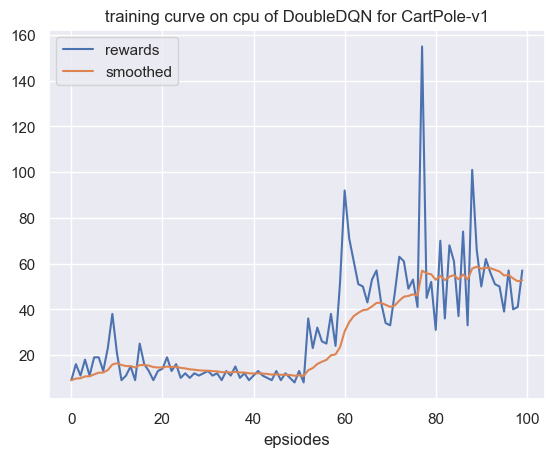

开始测试！
环境：CartPole-v1, 算法：DoubleDQN, 设备：cpu
回合：1/10，奖励：117.0，步数：117
回合：2/10，奖励：89.0，步数：89
回合：3/10，奖励：72.0，步数：72
回合：4/10，奖励：40.0，步数：40
回合：5/10，奖励：76.0，步数：76
回合：6/10，奖励：78.0，步数：78
回合：7/10，奖励：76.0，步数：76
回合：8/10，奖励：87.0，步数：87
回合：9/10，奖励：76.0，步数：76
回合：10/10，奖励：98.0，步数：98
完成测试！


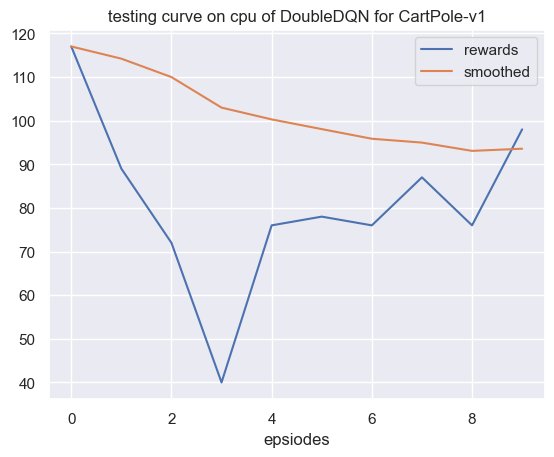

In [62]:
cfg = get_args()
env, agent = env_agent_config(cfg)
res_dic = train(env, agent, cfg)
plot_rewards(res_dic['rewards'], cfg, tag='train')

res_dic = test(env, agent, cfg)
plot_rewards(res_dic['rewards'], cfg, tag='test')